## Document Classification with InceptionV3

With the increasing digitization of processes in various industries that deal with vast amounts of archives, there is a growing interest in Document Image Processing (DIP). This technology results in significant cost savings for the company and enhances the user experience, as the customer is no longer required to enter the data manually. An integral part of this technology is the automated assignment of a document to a specific
document class to be able to perform subsequent document-specific text extractions.
This document classification task can bei performed using either context-based (NLP, e.g. BERT) or structure-based (CV, e.g. CNNs) approaches. In the following, we want to follow the latter approach and train a CNN to classify the documents.

The InceptionV3 is one of the best known and best performing CNN architectures. The weights — pre-trained on ImageNet — can be conveniently imported with Pytorch and fine-tuned on a custom dataset (in our case the Tobacco3482 dataset).

### 0 Import modules 

The following packages are utilized in the analysis and must therefore be imported before use:

In [1]:
import torch
import sys
from PIL import Image
import os
import numpy as np
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
import pathlib
import yaml
from yaml.loader import SafeLoader
from helpers import get_file_paths_and_labels, initialize_model, CustomImageDataset, train_inception, test_accuracy, main
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt 
from ray import tune

### 1 Parse config parameters 

For the use of the dataset and the later training of the model, the config.yaml file must be adapted. This contains the most important parameters that are used for the following cells of this notebook.

In [2]:
with open('config.yaml') as f:
    config = yaml.load(f, Loader=SafeLoader)
    print(config)

{'IMAGE_DIR': 'C://Users//Johannes//Documents//Tobacco3482-jpg', 'NUM_CLASSES': 10, 'NUM_EPOCHS': 15, 'VAL_SPLIT_REL': 0.1, 'TEST_SPLIT_REL': 0.1, 'NUM_SAMPLES': 15, 'INPUT_SIZE': 299, 'SAVE_DIR': './model', 'HYPERPARAMETER_GRID': {'lr': 'tune.loguniform(1e-4, 1e-1),', 'batch_size': 'tune.choice([4, 8, 16]),', 'mom': 'tune.choice([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),', 'weight_decay': 'tune.loguniform(0.001, 0.1),', 'num_epochs': 15}}


In [3]:
image_dir = config["IMAGE_DIR"]
num_classes = config["NUM_CLASSES"]
num_epochs = config["NUM_EPOCHS"]
num_samples = config["NUM_SAMPLES"]
input_size = config["INPUT_SIZE"]
hyperparameter_grid = config["HYPERPARAMETER_GRID"]
save_dir = config["SAVE_DIR"]

### 3 Description of Input Data

Since we want to investigate the classification of documents, we choose the openly accessible dataset Tobacco3482 consisting of 3482 single-page scans, divided into 10 different classes (ADVE, Email, FOrm, Letter, Memo, News, Note, Report, REsume, Scientific) of business documents that orginate from the tobacco industry. The dataset was introduced by Kumar et. al (2013). 

### 4 Strategy for solving the problem

As already mentioned, the task of classifying document images can be performed using either context-based or structure-based approaches. In the following, we want to follow the latter approach and train a CNN to classify the documents. In doing so, we chose one of the most well-known Convolutional Neural Networks, the InceptionV3, to handle the classification task.

### Discussion of the expected solution

Classification of documents using CNNs has already proven to be very suitable in the past. Although authors like Ferrando et al. (2020) used a different dataset (the RVL-CDIP, which is much larger) and a different CNN (the Efficientnet), we follow a similar approach of fine-tuning a pre-trained CNN and have very similar classes in our dataset.
Harley et al. (2015) also attempted document classification using the RVL-CDIP and the VGG16 and followed a similar approach with success. 
Although our dataset is significantly smaller than that of these two papers, we assume that document classification is also possible on this dataset using a CNN and yields good results. 

### Exploratory Data Analysis

In the first step, we prepare the paths and the labels of the images in a dataframe. Thereby, image_dir is the path to which we have saved the dataset.
The the get_file_paths_and_labels function returns a pandas dataframe with a column that contains the path to each image and the corresponding label. Next to that we return a dictionary that matches each class to a integer to train the model. 

In [7]:
data_dir = pathlib.Path(image_dir)
labels_df, label_to_index = get_file_paths_and_labels(data_dir)

The assignment of the classes to the integers looks like this: 

In [8]:
for i, (label_name, label_int) in enumerate(label_to_index.items()):
    print(label_int, label_name)

0 ADVE
1 Email
2 Form
3 Letter
4 Memo
5 News
6 Note
7 Report
8 Resume
9 Scientific


We are also interested in what the document classes look like. We will look at this with one example per class:

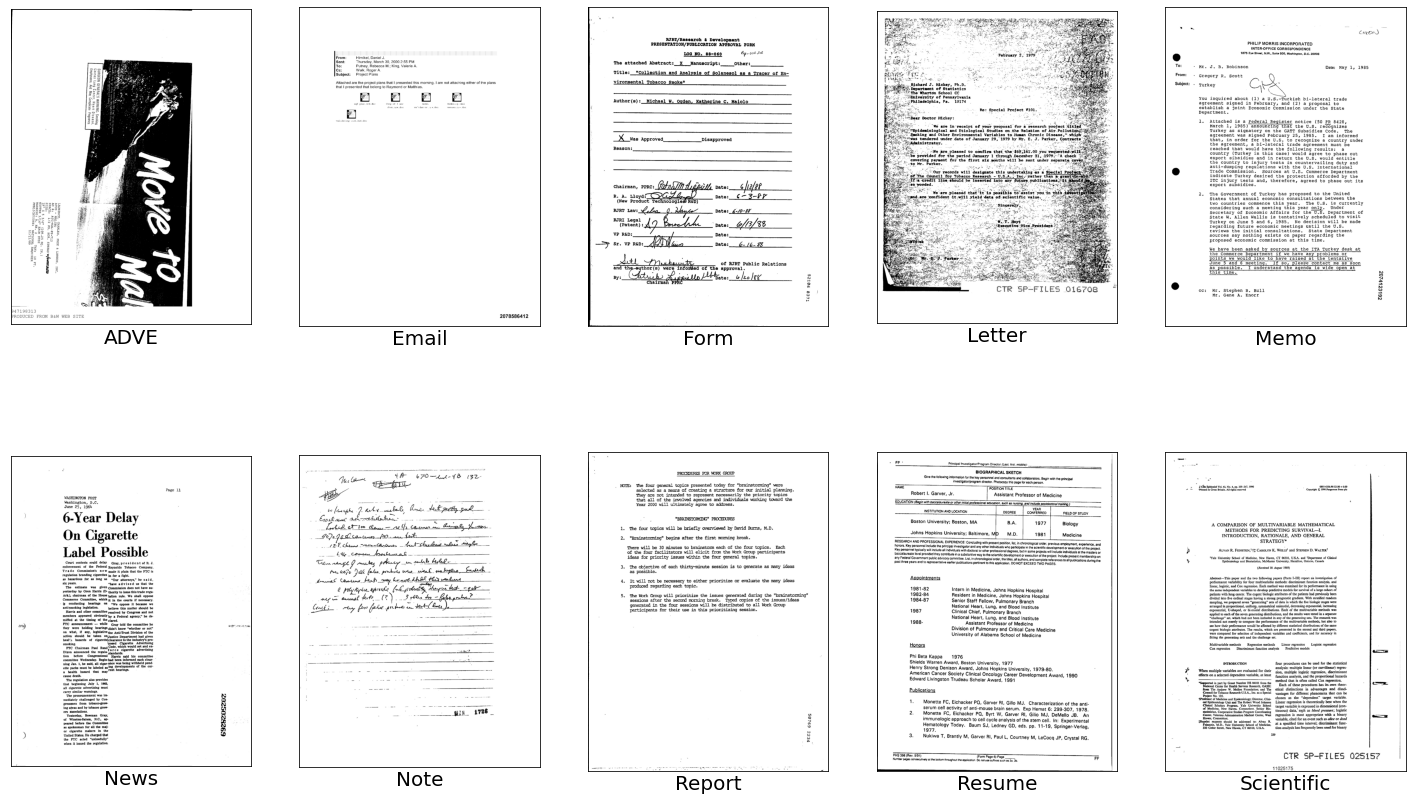

In [9]:
plt.figure(figsize=(25, 15))
for i, (label_name, label_int) in enumerate(label_to_index.items()):
    sample_idx = labels_df[labels_df.label == label_int].index[0]
    image_path = labels_df.path[sample_idx]
    img = Image.open(os.path.join(image_dir, image_path)).convert('1')
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel(label_name, fontsize=20)
plt.show()

In the plot we can see that classes comprise different document types including printed documents and hand-written manuscripts. The printed documents range from instances with many graphical elements and little text (e.g., the class Advertisement) to predominantly text-based documents (e.g., class Scientific). 
However, a document category that contains mainly handwritten Schrift is the class form.

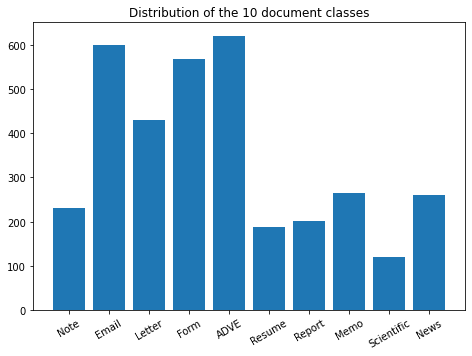

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(labels_df.label.value_counts().index, labels_df.label.value_counts().values)
ax.set_title("Distribution of the 10 document classes")
plt.xticks(labels_df.label.value_counts().index, rotation=30)
ax.set_xticklabels(list(label_to_index.keys()));

The number of documents per class differs across the document categories, which means class imbalance.
Overrepresented classes are Email, Form and ADVE, each consisting of about 600 documents. 

In contrast, the three most underrepresented classes are Resume, Report, and Scientific, each of which has between 100 and 200 documents. 


### Metrics for justification 

In classification tasks, the accuracy is the most common metric for measuring the predictive power of the model. It should be noted that accuracy is inappropriate if the classes are too unbalanced. Although the Tobacco2482's classes are imbalanced, the imbalance is small enough, which is why we decided to use accuracy. 

### Data Preprocessing

Before we define our Pytorch Dataset class, we want to specify transformations of the images. We have to distinguish between the transformations of the training data in contrast to the validation and test data : while we want to apply additional image augmentation methods to the training data to avoid overfitting, the test- and validation data should solely be normalized and adapted to the input size of the InceptionV3:

In [13]:
transforms_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

transforms_test = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

Next we can create the custom dataset class. This inherits from the pytorch dataset class and always requires the three methods __init__(), __len__() and __getitem__(). 
*Note: The imported class can be found in the helper.py file*.

We create two instances of this class, one with the transformations for the training data and one with the transformations of the test - and the validation data:

In [14]:
train_dataset = CustomImageDataset(transforms_train, labels_df, image_dir)
test_dataset = CustomImageDataset(transforms_test, labels_df, image_dir)
val_split_rel = 0.1
test_split_rel = 0.1

Based on this, we create our training, validation - and testing splits with help of the Pytorch SubsetRandomSampler:

In [15]:
dataset_size = labels_df.shape[0]
indices = list(range(dataset_size))
val_split = int(np.floor(val_split_rel * dataset_size))
test_split = val_split * 2
train_indices = indices[test_split:]
val_indices = indices[:val_split]
test_indices = indices[val_split:test_split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

### 8 Modeling & Hyperparameter Tuning 

During training, the parameters used to train the model (Hyperparameters) have a considerable influence on the quality of the model. That is why we want to integrate hyperparameter tuning into the usual training workflow of Pytorch. This works very well with Ray Tune, an industry standard tool for distributed hyperparameter tuning. Furthermore, it includes the latest hyperparameter search algorithms and integrates with TensorBoard as well as other analysis libraries.
*Note: The imported functions can be found in the helper.py file*.

#### 8.1 Training 

To use Ray Tune for our training and tuning, we need to define a training function. This function requires at least a config parameter, which can later be used to specify the hyperparameter grid. Conversely, this means that all elements containing hyperparameters that are to be varied later must be integrated in this training function.
We limit our hyperparameter search to the learning rate, batch_size, momentum, weight_decay and the number of epochs (feel free to integrate further hyperparameters in your tuning).
The batch size is crucial for the Pytorch Dataloader. Since the tuning only affects the training and validation split, we define the Pytorch Dataloader as the first part of the training function for both and bundle them in a joint dictionary.
As a next step inside the training function, we initialize the Inception with our custom initialize_model() function, set it to the available resources (either CPU or GPU) and make use of Pytorch distributed training, if more than one GPU is available. 

The next step in the train_inception() function is calling the initialize_model() function which imports the InceptionV3 from torchvision. A special characteristic when finetuning the InceptionV3 in contrast to other model architectures is that this network has two output layers during training. Thereby, the second output is called auxiliary output and is part of the AuxLogits part of the network. However, when testing the model, only the primary output, a linear layer at the end of the network, is considered. For training, though, we need to align both layers to the number of document classes.

Another part of the train_inception() is the criterion towards which the training should be optimized and the optimizer itself. The optimizer (in our case we decided on the Stochastic Gradient Descent (SGD)) contains hyperparameters (learning rate, momentum and weight decay) that we want to optimize.

After that, the training worklow follows. Thereby, we loop over the number of epochs we want to train our model for. Within each epoch, all training data is batched through the dataloader and fed into the network. The prediction is then compared with the true label, from which the loss (in our case of the InceptionV3 two losses) is calculated. The latter is then taken by the optimizer (in our case the Stochastic Gradient descent) to optimize the weights of the InceptionV3. At the end of each epoch, the InceptionV3 is applied batchwise to the validation data in order to be able to report both the validation loss and the accuracy on the validation set at the end of each epoch.

#### 8.2 Hyperparameter Tuning 

*Note: The implementation of the procedure described below refers to the main() function in the helpers.py file*

As already mentioned, we will use Ray for hyperparameter optimisation. We will do this with the help of Ray’s Tune module. Thereby we make use of the tune.run() method. It requires the following components as arguments:

  -  The config
  -  The scheduler
  -  The reporter

In the config we define the hyperparameter grid we want to sample combinations from in each run.

The scheduler and the reporter are used to schedule the runs and logs metrics in the console output. In addition, we define how many experiments (max_t) we want to sample on the hyperparameter grid. Next to these components we specify the number of samples to be drawn from the hyperparameter grid, aka the number of experiments.

In a last step of our training procedure, we need to ensure that this model performs equally well on a hold-out-set. For this, we withheld a test set in splitting at the beginning that neither the model itself saw during training nor we used for the model selection. We define another function to apply the selected model on the test data and thereby calculate the accuracy:

As input for our test_accuracy() function we have to load our best model. To do this, we call our previously discussed initialize_model() function, tell the returned model which resources we want to use and load the weights of our best model:

All these building blocks together make up our final main() function of our training pipeline.

#### 8.2 Run Training and Tuning 

In order to train and tune the Inception V3, we call the main function. This contains all the steps described above and selects the best model: 

In [ ]:
main(hyperparameter_grid, save_dir, num_samples=num_samples, max_num_epochs=num_epochs)

### Results & Comparison Table

In the first run of the training and hyperparamter tuning we sample 5 different combinations of hyperparameters. The values shown in the table are sampled and for each of these combinations the InceptionV3 is tuned for 12 epochs: 

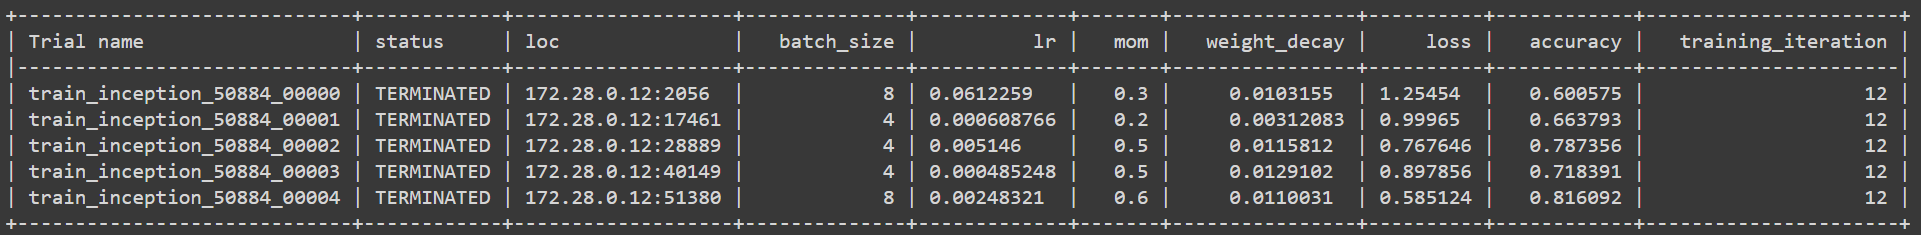

Here we can see that the best run (learning rate = 0.00248321, momentum = 0.6, weight decay = 0.0110031, number of epochs = 12) archieved a validation accuracy of 81.61%. Thereby we can see that the combinations were very limited as e.g. for none of the runs a higher batch size than 8 was sampled.

Therefore we have started the tuning again with 20 combinations to cover more combinations. This tuning run resulted in a best combination of a learning rate (lr) of 0.0043, a batch size of 8, a momentum (mom) of 0.6, a weight decay of 0.008 and 12 epochs. With this hyperparameter combination the highest validation accuracy of 84.6% could be achieved.

In [21]:
sys.path.append("../")

In [35]:
best_config = {
    "lr": tune.choice([0.0043]),
    "batch_size": tune.choice([8]),
    "mom": tune.choice([0.6]),
    "weight_decay": tune.choice([0.008]),
    "num_epochs": tune.choice([12])
}

best_trained_model = initialize_model()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
best_trained_model.to(device)
model_state, optimizer_state = torch.load(os.path.join(save_dir, "checkpoint.zip"), map_location=torch.device(device))
best_trained_model.load_state_dict(model_state)

test_acc = test_accuracy(best_trained_model, best_config, test_dataset, test_sampler, device)
print("Best trial test set accuracy: {}".format(test_acc))

Best trial test set accuracy: 0.853448275862069


In order to additionally evaluate the selected model on a hold out set, we additionally apply the model on the test set that was set aside at the beginning of our analysis.
On this data set, we even achieve an accuracy of 85.5% with the model.

### Conclusion 

With the chosen approach of using the Inceptionv3 to classify the Tobacco3482 document classes, very good results were achieved (i.e. a validation accuracy of 84.6% and a test accuracy of 85.3%). Thereby, hyperparameter tuning using Ray Tune allowed the best combination of hyperparameters to be found. 

### Discussion

From a business perspective this project to classify documents with the help of a CNN was particularly interesting because document classification has many real-world applications, such as in the field of digital archiving, where large volumes of documents need to be categorized and stored for future reference. The ability to accurately classify documents can save significant time and resources in industries such as legal, finance, and healthcare

From a technical perspective, on the other hand, this project was particularly interesting because it showed once again how much influence the choice of the right hyperparameters have on the training. If e.g. the learning rate is chosen too high or too low, an optimum is either not reached (oscillation) or remains stuck in a local optimum. The addition of the momentum further reduces the risk of the latter problem.

### Improvement 

Further improvements of the model quality can be achieved by adding further hyperparameters to the optimization (e.g. a dropout rate). An alternative would be to perform a full grid search instead of randomly selecting only 15 hyperparameter combinations.  Also, the model could first be pre-trained on a larger document dataset such as the RVL-CDIP and then fine-tuned on the Tobacco3482. Another option would be to choose a more complex network architecture, such as the follow-up InceptionV4. 

### Acknowledgement 

- Ferrando, J., J. L. Domnguez, J. Torres, R. Garca, D. Garca, D. Garrido, J. Cortada, and
M. Valero (2020). Improving accuracy and speeding up document image classification
through parallel systems. International Conference on Computational Science – ICCS 2020.
ICCS 2020. Lecture Notes in Computer Science, vol 12138. Springer, Cham 12138, 387–400.

- Harley, A. W., A. Ufkes, and K. G. Derpanis (2015). Evaluation of deep convolutional nets
54
for document image classification and retrieval. In International Conference on Document
Analysis and Recognition (ICDAR).

- Jayant Kumar, Peng Ye and David Doermann. "Structural Similarity for Document Image Classification and Retrieval." Pattern Recognition Letters, November 2013. 

- https://www.kaggle.com/datasets/patrickaudriaz/tobacco3482jpg
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html
- https://docs.ray.io/en/latest/tune/examples/tune_analyze_results.html
- https://docs.ray.io/en/latest/tune/api_docs/schedulers.html
- https://docs.ray.io/en/latest/tune/api_docs/reporters.html
- https://arxiv.org/pdf/2004.07922v1.pdf